In [9]:

import matplotlib.pyplot as plt
import pandas as pd
import pickle
import seaborn as sns
from pyprojroot import here
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Patch 
from matplotlib.ticker import PercentFormatter

## Style

In [10]:
# colors=['#f2d138','#19bdff'] #majority/minority
myblack='#222222'
darkgray='#333333'
mediumgray='#a9abaf'
colors = {
    'Supports': '#19bdff',
    'Neutral': '#cfcfcf',
    'Opposes': '#f2d138',
    'Debate': '#63ba65',
    'Other': '#FFFFFF',
    'Other_outline': '#999999'
}

outlet_colors = {
    'ABC': '#f37621',
    'CBS': '#f8c115',
    'CNN': '#4e79a7',
    'Fox': '#a02f2e',
    'MSNBC': '#7caed4',
    'NBC': '#808e54',
    'PBS': '#bfa796'
}

policy_colors = {
    'Paris Agreement':          '#1f77b4',  # blue
    'Green New Deal':           '#2ca02c',  # green
    'Executive action':         '#ff7f0e',  # orange
    'Emergency declaration':    '#d62728',  # red
    '(De)regulation and laws':  '#9467bd',  # purple
    'Renewable energy':         '#17becf',  # cyan
    'Emission reduction':       '#8c564b',  # brown
    'Oil and gas industry':     '#e377c2',  # pink
    'Other climate policy':     '#bcbd22'   # yellow-green
}


## Import data

In [11]:
policy_transcript_df=pd.read_csv(here('00_data_processing/output/policy_valence_summary_transcript_weighing.csv')) 
policy_annotation_df=pd.read_csv(here('00_data_processing/output/policy_valence_summary_annotation_weighing.csv'))
policy_by_outlet_df=pd.read_csv(here('00_data_processing/output/policy_transcript_counts_by_outlet.csv'))
other_df=pd.read_csv(here('00_data_processing/output/other_climate_policy_clean.csv'))

In [12]:
other_df = other_df[other_df['Policy or not'] == True]

In [13]:
percent_df = policy_transcript_df.copy()
percent_df['percent_total'] = percent_df[['Supports', 'Neutral', 'Debate', 'Opposes']].sum(axis=1) / 750 * 100
percent_df = percent_df[['policy_category', 'percent_total']]
percent_df = percent_df.sort_values(by='percent_total', ascending=False)


In [14]:
all_policies = ['Paris Agreement', 'Green New Deal', 'Executive action', 'Emergency declaration',
                  '(De)regulation and laws', 'Renewable energy', 'Emission reduction',
                  'Oil and gas industry', 'Other climate policy']

no_other_policies = ['Paris Agreement', 'Green New Deal', 'Executive action', 'Emergency declaration',
                  '(De)regulation and laws', 'Renewable energy', 'Emission reduction',
                  'Oil and gas industry']

only_concrete_policies= ['Paris Agreement', 'Green New Deal', 'Emergency declaration',
                  'Renewable energy', 'Emission reduction',
                  'Oil and gas industry', 'Other climate policy']

regulation_col = '(De)regulation and laws'
executive_action_col = 'Executive action'


## Plot figure 3

In [15]:


def plot_combined_policy_panels(
    df_response, df_outlet, percent_df,
    keylist,
    response_colors,
    outlet_colors,
    panel_titles=None,
    dpival=300
):
    myblack = '#222222'
    if panel_titles is None:
        panel_titles = ["A. Attitude toward policy", "B. News outlet", "C. Frequency"]

    response_categories = ['Supports', 'Opposes', 'Neutral', 'Debate']
    pad_size = 20

    # --- Sort by percent_total ASCENDING ---
    df_p = percent_df[percent_df['policy_category'].isin(keylist)].copy()
    df_p = df_p.sort_values('percent_total', ascending=True)
    keylist_sorted = df_p['policy_category'].tolist()
    df_p = df_p.reset_index(drop=True)

    # --- Prepare Sentiment Data ---
    df_r = df_response[df_response['policy_category'].isin(keylist_sorted)].copy()
    df_r['policy_category'] = pd.Categorical(df_r['policy_category'], categories=keylist_sorted, ordered=True)
    df_r = df_r.sort_values('policy_category')
    df_r_plot = df_r.set_index('policy_category')[response_categories]
    df_r_plot = df_r_plot.div(df_r_plot.sum(axis=1), axis=0) * 100

    # --- Prepare Outlet Data ---
    df_o = df_outlet[df_outlet['policy_category'].isin(keylist_sorted)].copy()
    df_o['policy_category'] = pd.Categorical(df_o['policy_category'], categories=keylist_sorted, ordered=True)
    df_o = df_o.sort_values('policy_category')
    df_o_plot = df_o.set_index('policy_category').drop(columns='policy_category', errors='ignore')
    df_o_plot = df_o_plot.div(df_o_plot.sum(axis=1), axis=0) * 100

    # --- Reorder outlet stack by total mentions (descending) ---
    outlet_totals = df_o_plot.sum(axis=0).sort_values(ascending=False)
    custom_order = ['CNN', 'Fox', 'MSNBC'] + [c for c in outlet_totals.index if c not in ['CNN', 'Fox', 'MSNBC']]
    outlet_categories = [c for c in custom_order if c in outlet_totals.index]
    df_o_plot = df_o_plot[outlet_categories]

    # --- Set up figure with 1:2:2 ratio ---
    fig = plt.figure(figsize=(7, 3), dpi=dpival)
    gs = GridSpec(nrows=1, ncols=5, figure=fig)
    ax1 = fig.add_subplot(gs[0, 0:2])
    ax2 = fig.add_subplot(gs[0, 2:4])
    ax3 = fig.add_subplot(gs[0, 4])

    # --- Plot Sentiment to get bar height ---
    df_r_plot.plot(kind='barh', stacked=True, color=[response_colors[c] for c in response_categories],
                   ax=ax1, legend=False, fontsize='small')
    bar_height = ax1.patches[0].get_height()

    # --- Panel 1: Sentiment ---
    ax1.set_xlim(0, 100)
    ax1.set_xlabel("% Transcripts", fontsize='small', color=myblack)
    ax1.xaxis.set_major_formatter(PercentFormatter(xmax=100))
    ax1.tick_params(axis='x', colors=myblack, labelsize='x-small')
    ax1.set_title(panel_titles[0], fontsize='small', color=myblack, pad=pad_size)
    ax1.set_ylabel(None)
    ax1.tick_params(axis='y', colors=myblack)
    yticklabels = [label if label != "Oil and gas industry" else "Oil and gas regulation" for label in df_r_plot.index.tolist()]
    ax1.set_yticklabels(yticklabels, fontsize='x-small', color=myblack)
    sns.despine(ax=ax1)
    ax1.spines[['left', 'bottom']].set_color(myblack)

    # Annotate sentiment percentages
    for i, row in enumerate(df_r_plot.itertuples(index=False)):
        left = 0
        for val, cat in zip(row, response_categories):
            if val >= 10:
                ax1.text(left + val / 2, i, f"{val:.0f}%", va='center', ha='center',
                         color='white', fontsize='x-small')
            left += val

    # Legend for sentiment (just below title) — square patches
    custom_resp_order = ['Supports', 'Opposes', 'Neutral', 'Debate']
    resp_handles = [Patch(facecolor=response_colors[c], edgecolor='none') for c in custom_resp_order]
    ax1.legend(
        handles=resp_handles,
        labels=custom_resp_order,
        loc='upper left',
        bbox_to_anchor=(0, 1.15),
        frameon=False,
        fontsize='x-small',
        ncol=2,
        handletextpad=0.4,
        handlelength=1,   
        handleheight=1,
        columnspacing=0.6,
        borderaxespad=0.,
        labelspacing=0.3
    )

    # --- Panel 2: Outlet ---
    df_o_plot.plot(kind='barh', stacked=True, color=[outlet_colors[c] for c in outlet_categories],
                   ax=ax2, legend=False, fontsize='small')
    ax2.set_xlim(0, 100)
    ax2.set_xlabel("% Transcripts", fontsize='small', color=myblack)
    ax2.xaxis.set_major_formatter(PercentFormatter(xmax=100))
    ax2.tick_params(axis='x', colors=myblack, labelsize='x-small')
    ax2.set_title(panel_titles[1], fontsize='small', color=myblack, pad=pad_size)
    ax2.set_ylabel(None)
    ax2.tick_params(axis='y', colors=myblack)
    ax2.set_yticklabels([])
    ax2.set_yticks([])
    sns.despine(ax=ax2)
    ax2.spines[['left', 'bottom']].set_color(myblack)

    # Annotate outlet percentages
    for i, row in enumerate(df_o_plot.itertuples(index=False)):
        left = 0
        for val, cat in zip(row, outlet_categories):
            if val >= 10:
                ax2.text(left + val / 2, i, f"{val:.0f}%", va='center', ha='center',
                         color='white', fontsize='x-small')
            left += val

    # Legend for outlet — square patches
    custom_outlet_order = ['CNN', 'Fox', 'MSNBC'] + [c for c in outlet_categories if c not in ['CNN', 'Fox', 'MSNBC']]
    outlet_handles = [Patch(facecolor=outlet_colors[c], edgecolor='none') for c in custom_outlet_order]
    ax2.legend(
        handles=outlet_handles,
        labels=custom_outlet_order,
        loc='upper left',
        bbox_to_anchor=(0, 1.15),
        frameon=False,
        fontsize='x-small',
        ncol=4,
        handletextpad=0.4,
        handlelength=1,   
        handleheight=1,
        columnspacing=0.6,
        borderaxespad=0.,
        labelspacing=0.3
    )

    # --- Panel 3: Coverage ---
    ax3.barh(
        y=df_p['policy_category'],
        width=df_p['percent_total'],
        color=mediumgray,
        # edgecolor=darkgray,
        linewidth=0,
        height=bar_height
    )
    ax3.set_xlim(0, 100)
    ax3.set_xlabel('% Transcripts', fontsize='small', color=myblack)
    ax3.xaxis.set_major_formatter(PercentFormatter(xmax=100))
    ax3.tick_params(axis='x', colors=myblack, labelsize='x-small')
    ax3.set_title(panel_titles[2], fontsize='small', color=myblack, pad=pad_size)
    ax3.set_ylabel(None)
    ax3.tick_params(axis='y', colors=myblack)
    ax3.set_yticklabels([])
    ax3.set_yticks([])
    ax3.spines[['left', 'bottom']].set_color(myblack)
    ax3.spines[['top', 'right']].set_visible(False)

    # Add percent annotations
    for i, val in enumerate(df_p['percent_total']):
        ax3.text(val + 1, i, f"{round(val)}%", va='center', ha='left',
                 fontsize='x-small', color=myblack)

    # Reserve space for legends and titles
    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.savefig(here('99_figures/combined_policy_panels.pdf'), dpi=dpival, bbox_inches='tight')
    plt.show()


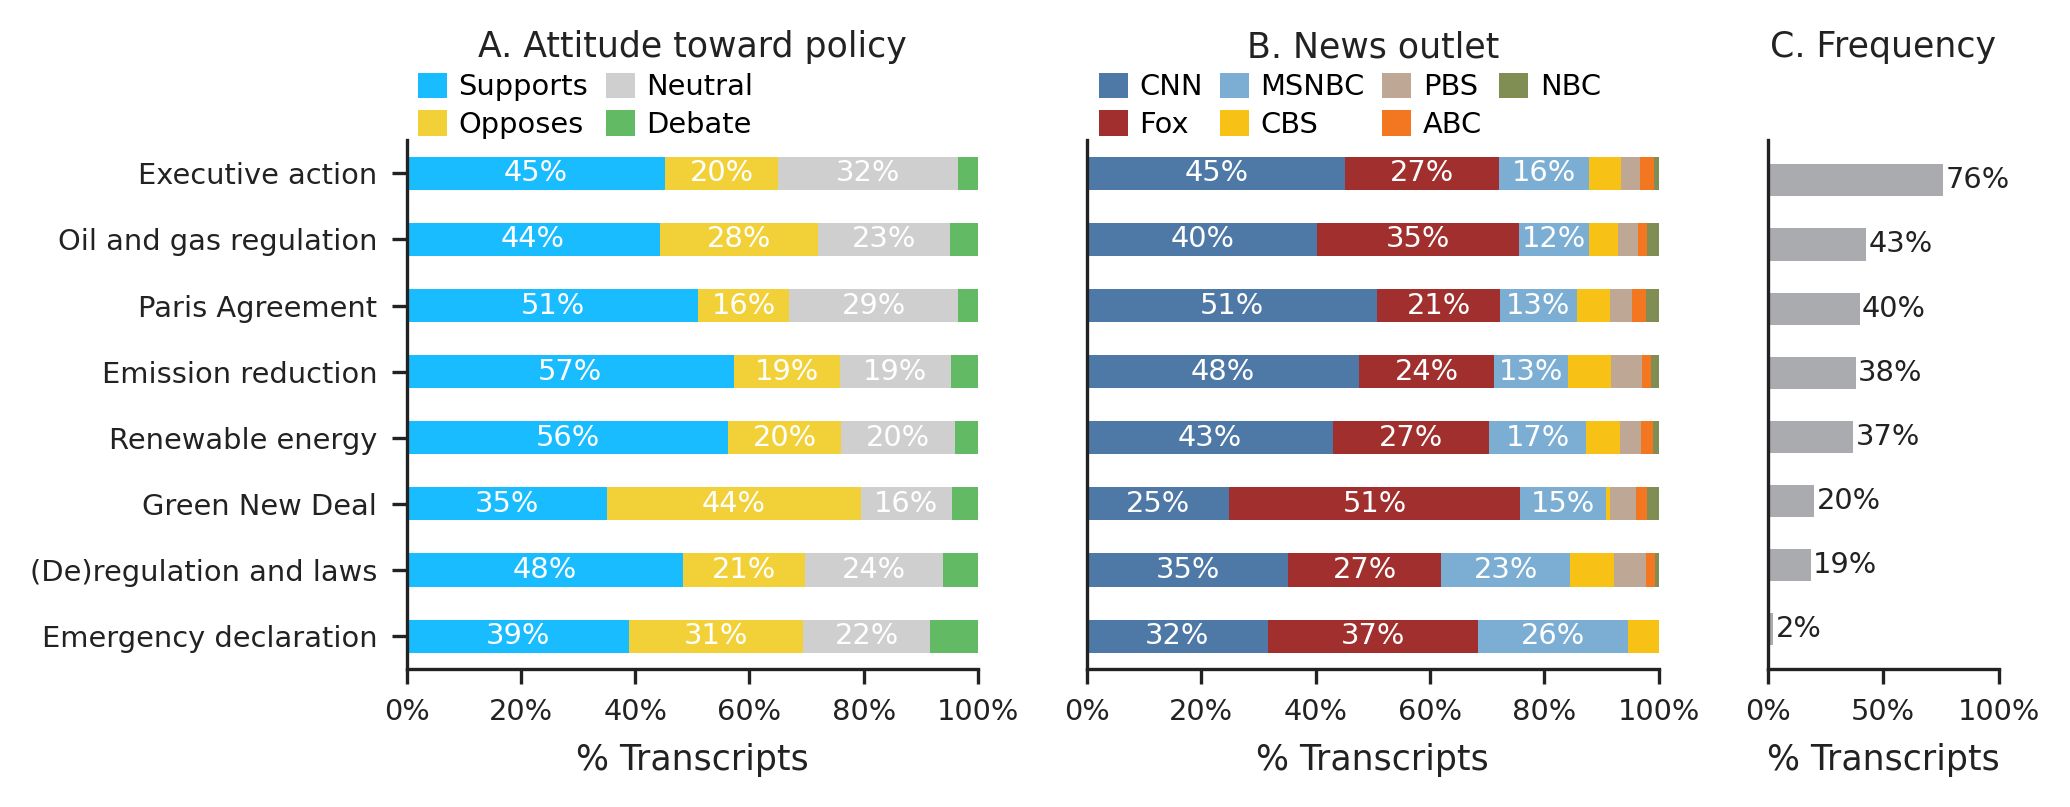

In [16]:
plot_combined_policy_panels(
    df_response=policy_transcript_df,
    df_outlet=policy_by_outlet_df,
    percent_df=percent_df,
    keylist=no_other_policies,
    response_colors=colors,
    outlet_colors=outlet_colors
)